# Analysis

In [28]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

df = pd.read_csv("75015.csv")

In [3]:
df

,Unnamed: 0,car_plate_number,status,group_id,kibana_duration,distance,zipcode,delta_battery,latitude,longitude,end_hour,end_minutes,duration,year,month,day_number,hour,minute,day_of_week
0,0,FZ-431-RF,FREE,Client,142,0.0,75015,0.0,48.841396,2.302687,1,46,142,2022,May,8,23,24,6
1,1,GB-797-JX,FREE,Client,162,0.0,75015,54.0,48.828094,2.271857,1,23,162,2022,May,8,22,41,6
2,2,FZ-797-RF,FREE,Client,118,4.0,75015,-2.0,48.840595,2.288074,1,21,118,2022,May,8,23,23,6
3,4,GB-952-JX,BOOKED,Client,37,5.0,75015,-2.0,48.850243,2.348434,1,21,37,2022,May,9,0,44,0
4,5,FC-897-BK,BOOKED,Client,159,23.0,75015,-9.0,48.850330,2.288824,1,20,159,2022,May,8,22,41,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79709,115970,FA-652-MN,RESERVED,Client,10,-6707690.0,75015,-0.3,48.854140,2.292160,18,12,10,2020,Nov,24,18,2,1
79710,115971,FB-456-TV,BOOKED,Client,20,15500.0,75015,-5.7,48.828220,2.292110,18,7,20,2020,Nov,24,17,47,1
79711,115973,FB-366-TV,BOOKED_PARKED,Client,4,0.0,75015,-0.3,48.850140,2.286610,17,57,4,2020,Nov,24,17,53,1
79712,115975,FA-713-MN,FREE,Client,9,0.0,75015,-1.5,48.842220,2.285440,17,27,9,2020,Nov,24,17,18,1


In [4]:
def geo_block(dataframe, district):
    return dataframe[dataframe['zipcode']==district]

def time_block(dataframe, start_time, end_time, scripted_day):
    return dataframe.loc[(dataframe['hour']>= start_time) & (dataframe['hour']<= end_time) & (dataframe['day_of_week']==scripted_day)]

def time_block_extended(dataframe, start_time, end_time, scripted_day1, scripted_day2):
    return dataframe.loc[(dataframe['hour']>= start_time) & (dataframe['hour']<= end_time) & (dataframe['day_of_week']>=scripted_day1) & (dataframe['day_of_week']<=scripted_day2)]

    

In [5]:
time_blocks = [(0, 5), (6, 9), (10, 11), (12, 13), (14, 15), (16, 18), (19, 23)] # obtained from the daily num
geo_blocks = df['zipcode'].unique()
days = np.sort(df['day_of_week'].unique())
days_dict = {1: "Monday", 2:"Tuesday", 3:"Wednesday", 4:"Thursday", 5:"Friday", 6: "Saturday", 7: "Sunday"}

In [6]:
def free_duration_max(dataframe, district, start_date, end_date, day):
    dataframe = geo_block(dataframe, district)
    dataframe = time_block(dataframe, start_date, end_date, day)
    return dataframe.loc[dataframe['status']=='FREE']['kibana_duration'].max()

In [7]:
def free_duration_min(dataframe, district, start_date, end_date, day):
    dataframe = geo_block(dataframe, district)
    dataframe = time_block(dataframe, start_date, end_date, day)
    return dataframe.loc[dataframe['status']=='FREE']['kibana_duration'].min()

In [8]:
def free_duration_mean(dataframe, district, start_date, end_date, day):
    dataframe = geo_block(dataframe, district)
    dataframe = time_block(dataframe, start_date, end_date, day)
    return dataframe.loc[dataframe['status']=='FREE']['kibana_duration'].mean()

In [9]:
def free_duration_std(dataframe, district, start_date, end_date, day):
    dataframe = geo_block(dataframe, district)
    dataframe = time_block(dataframe, start_date, end_date, day)
    return dataframe.loc[dataframe['status']=='FREE']['kibana_duration'].std()

In [10]:
def total_booked_cars(dataframe, district, start_date, end_date, day):
    dataframe = geo_block(dataframe, district)
    dataframe = time_block(dataframe, start_date, end_date, day)
    return len(dataframe.loc[dataframe['status']!='FREE'])

In [11]:
def total_free_cars(dataframe, district, start_date, end_date, day):
    dataframe = geo_block(dataframe, district)
    dataframe = time_block(dataframe, start_date, end_date, day)
    return len(dataframe.loc[dataframe['status']=='FREE'])

In [12]:
features = [total_free_cars, total_booked_cars, free_duration_std, free_duration_mean, free_duration_max, free_duration_min]
feature_names = ['total free cars', 'total booked cars', 'free duration standard deviation', 'free duration mean', 'max free duration', 'min free duration']

In [13]:
# Calculating features and storing results in a dedicated dataframe
array = np.empty(shape=(0, 4+len(features)))
for day, (start_date, end_date), district in itertools.product(days, time_blocks, geo_blocks):
    row = [district, day, start_date, end_date]
    for feature in features :
        row.append(feature(df, district, start_date, end_date, day))
    array = np.vstack([array, row])

results = pd.DataFrame(array, columns = ['district', 'day', 'start hour', 'end hour']+feature_names)
# results = results.astype(int)
results = results.replace({'day': days_dict})

In [14]:
results

,district,day,start hour,end hour,total free cars,total booked cars,free duration standard deviation,free duration mean,max free duration,min free duration
0,75015.0,0.0,0.0,5.0,340.0,432.0,896.023983,585.561765,9656.0,0.0
1,75015.0,0.0,6.0,9.0,497.0,1124.0,626.519139,391.450704,5150.0,0.0
2,75015.0,0.0,10.0,11.0,314.0,573.0,855.847651,479.541401,6224.0,0.0
3,75015.0,0.0,12.0,13.0,348.0,629.0,828.792481,454.479885,5492.0,0.0
4,75015.0,0.0,14.0,15.0,416.0,837.0,752.189719,426.759615,6627.0,0.0
5,75015.0,0.0,16.0,18.0,734.0,1391.0,796.578897,538.978202,7496.0,0.0
6,75015.0,0.0,19.0,23.0,669.0,1009.0,867.586800,656.457399,7136.0,0.0
7,75015.0,Monday,0.0,5.0,228.0,302.0,1057.389233,640.074561,12157.0,0.0
8,75015.0,Monday,6.0,9.0,564.0,1097.0,696.626721,446.281915,5700.0,0.0
9,75015.0,Monday,10.0,11.0,335.0,602.0,16628.556734,2183.758209,153255.0,0.0


## Durée de Disponibilité Moyenne

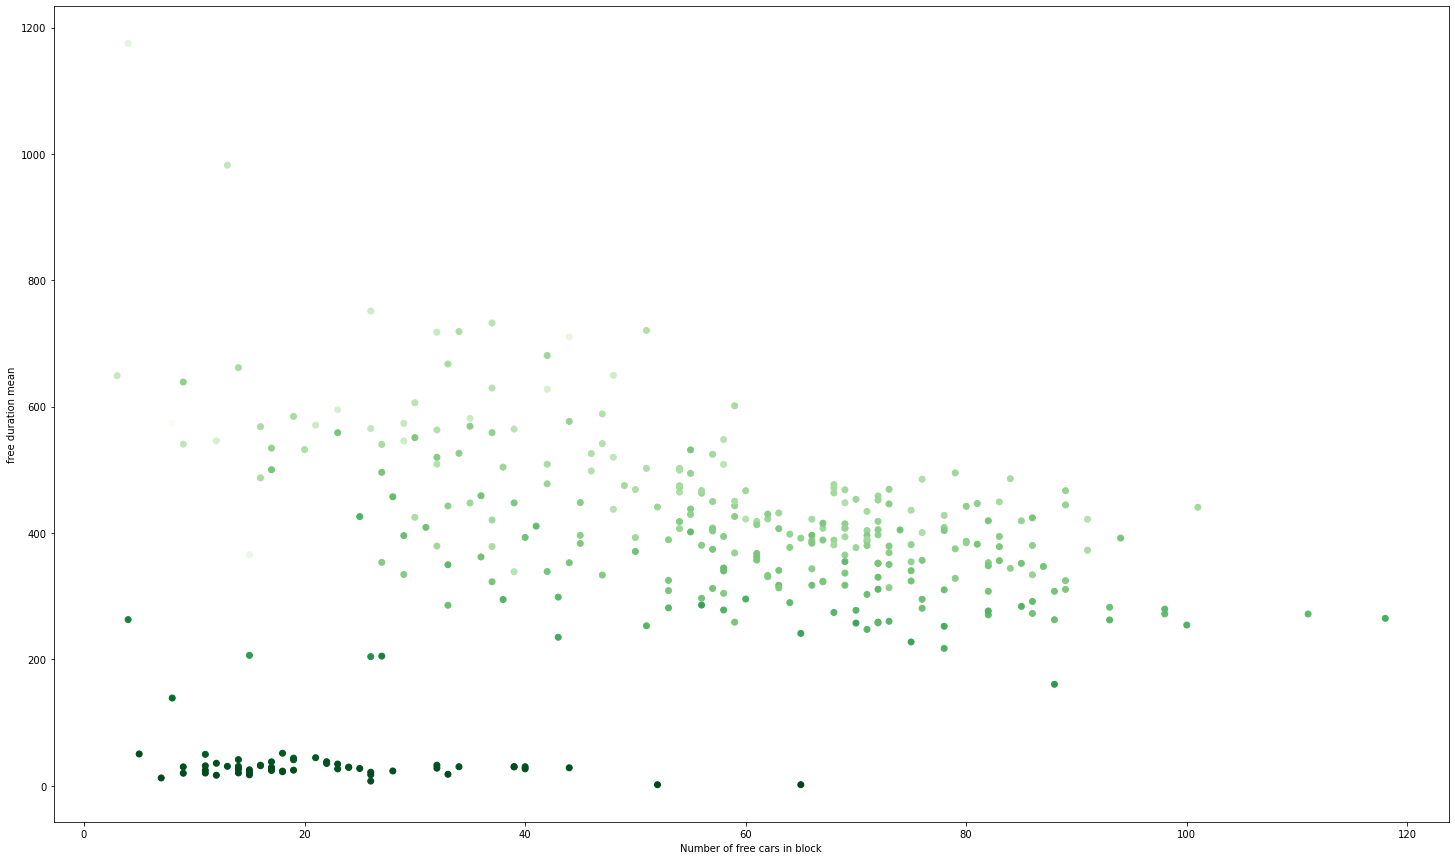

In [15]:
district = 75015
start_date = 0
end_date = 23
day = 0
end_day = 4
dataframe = geo_block(df, district)
dataframe = time_block_extended(dataframe, start_date, end_date, day, end_day).loc[dataframe["status"]=="FREE"]
dataframe = dataframe[dataframe['kibana_duration']<2000] # filter segments with duration > 2000 minutes = 33 hours
grouped_df = dataframe.groupby(by=['month', 'day_number', 'year']).agg({'year': 'first', 'month': 'first', 'day_number': 'first', 'kibana_duration': ['mean', 'count', 'std']})
durations_means = grouped_df['kibana_duration']['mean'].values
count = grouped_df['kibana_duration']['count'].values
dates = (grouped_df['year'].astype(str) + ", " + grouped_df['month']+ " " + grouped_df['day_number'].astype(str)).values
standards = grouped_df['kibana_duration']['std'].values
plt.figure(figsize=(25, 15))
# plt.plot(count, durations_means,'bo')
plt.scatter(count,  durations_means, c=standards, cmap='Greens_r')
plt.xlabel("Number of free cars in block")
plt.ylabel("free duration mean")
"""
for i, v in enumerate(count):
    plt.text(count[i], 1.01*durations_means[i]+3, "%s" %dates[i][0], ha="left")
"""
# plt.ylim(0, 5000)
plt.show()

## Nombre de Bookings

<ipython-input-68-90b01e8b04c2>:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a, _, _, _ = np.linalg.lstsq(x, y)


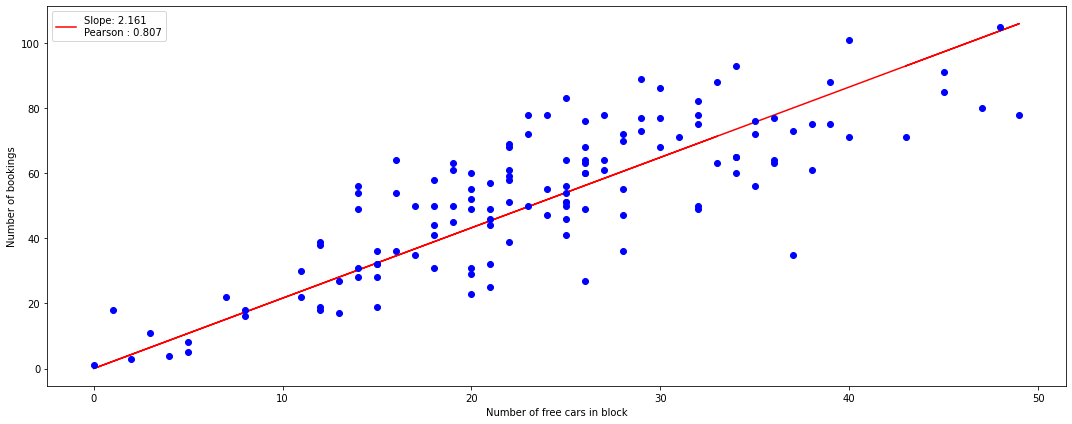

In [68]:
district = 75015
start_date = 10
end_date = 14
day = 5
end_day = 6
dataframe = geo_block(df, district)
dataframe = time_block_extended(dataframe, start_date, end_date, day, end_day)
dataframe = dataframe[dataframe['kibana_duration']<2000]
df1 = dataframe.groupby(by=['month', 'day_number', 'year'])['status'].apply(lambda x: (x!='FREE').sum()).reset_index(name='booked_count')
df2 = dataframe.groupby(by=['month', 'day_number', 'year'])['status'].apply(lambda x: (x=='FREE').sum()).reset_index(name='free_count')
booked_count = df1['booked_count'].values
free_count = df2['free_count'].values

x = np.array(free_count).reshape(-1, 1)
y = np.array(booked_count)
a, _, _, _ = np.linalg.lstsq(x, y)

pearson = pearsonr(free_count, booked_count)[0]

plt.figure(figsize=(15, 6))
plt.rcParams["figure.autolayout"] = True
plt.plot(free_count, a*free_count, c='red', label = "Slope: %a" %(int(a[0]*1000)/1000) + f"\nPearson : {(int(pearson*1000)/1000)}" )
plt.plot(free_count, booked_count, 'bo')
plt.xlabel("Number of free cars in block")
plt.ylabel("Number of bookings")
plt.legend(loc="upper left")
# plt.ylim(0, 5000)
plt.show()

## Corrélations

In [24]:
cor, days, starts, stops, lengths = [], [], [], [], []
for day in range(0, 7):
    for start_date, end_date in  time_blocks:
        dataframe = geo_block(df, district)
        dataframe = time_block(dataframe, start_date, end_date, day).loc[dataframe["status"]=="FREE"]
        dataframe = dataframe[dataframe['kibana_duration']<2000] # filter segments with duration > 2000 minutes = 33 hours
        grouped_df = dataframe.groupby(by=['month', 'day_number', 'year']).agg({'year': 'first', 'month': 'first', 'day_number': 'first', 'kibana_duration': ['mean', 'count', 'std']})
        durations_means = grouped_df['kibana_duration']['mean'].values
        count = grouped_df['kibana_duration']['count'].values
        try :
            cor.append(pearsonr(count, durations_means)[0])
            days.append(days_dict[day-1])
            starts.append(start_date)
            stops.append(end_date)
            lengths.append(len(count))
        except Exception as e:
            print(e)
cor_df = pd.DataFrame(list(zip(days, starts, stops, cor, lengths)), columns=['day', 'start hour',  'end hour', 'Pearson correlation coefficient', 'Number of blocks'])
cor_df
         

-1
-1
-1
-1
-1
-1
-1
0
0
0
0
0
0
0


,day,start hour,end hour,Pearson correlation coefficient,Number of blocks
0,Monday,0,5,0.043845,53
1,Monday,6,9,0.032585,67
2,Monday,10,11,0.105820,64
3,Monday,12,13,-0.024285,66
4,Monday,14,15,0.067944,63
5,Monday,16,18,0.117327,65
6,Monday,19,23,0.276303,63
7,Tuesday,0,5,-0.083709,58
8,Tuesday,6,9,0.377939,65
9,Tuesday,10,11,0.001060,59


# 2 PROBLÈMES MAJEURS
- En abscisse on n'a pas le nombre de voitures disponibles dans le bloc, seulement le nombre de segments "FREE" qui commencent dans le bloc. Mais il y a des voitures qui partent et des voitures qui étaient présentes avant.
- On peut estimer la demande dans un bloc, à savoir le nombre de voitures qui vont potentiellement être réservées dans ce bloc, mais ça ne nous donne pas le nombre target de voitures qu'il faut avoir en permanence dans le bloc

## Problèmes annexes ?
- Pas assez de données ? --> Essayer sur une autre ville que Paris

Use DBSCAN to get clusters ?
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
demand_estimation.pdf page 6

In [104]:
print(results['total booked cars'].sum())
print(results['total free cars'].sum())

34620
16215
